# Data acquisition/processing and full wave inversion demo using SPECFEM3D_GLOBE

In [1]:
# import necessary modules

%matplotlib inline
from obspy.clients.fdsn.mass_downloader import GlobalDomain
from obspy.clients.fdsn.mass_downloader import MassDownloader
from obspy.clients.fdsn.mass_downloader import Restrictions
from obspy.geodetics import locations2degrees
from obspy.signal.invsim import cosine_sac_taper
from obspy.signal.util import _npts2nfft
from obspy.imaging.beachball import beachball, beach

import obspy

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

import os

disp_unit = 'mm'

## Downloading Event Information and 1D/3D synthetic data

In this example, we use Global Centroid Moment Tensor (CMT) solution for the 2024 Noto Peninsula earthquake, which can be downloaded from [The Harvard Centroid Moment Tenosr Catalog Web Page](https://www.globalcmt.org/CMTsearch.html).  

We can also download the 1D/3D synthetic data for this event from the [Global Shake Movie of Princeton University](https://global.shakemovie.princeton.edu/event.jsp?evid=C202401010710A&mode=scientific)

Here is the CMT solution for the 2024 Noto Peninsula earthquake:

```
 PDEQ2024  1  1  7 10  9.70  37.5000  137.2400  10.0 0.0 7.5 NEAR WEST COAST OF HONSH
event name:     202401010710A
time shift:     29.4400
half duration:  14.2000
latitude:       37.4900
longitude:     137.1700
depth:          12.0000
Mrr:       2.260000e+27
Mtt:      -7.540000e+26
Mpp:      -1.510000e+27
Mrt:      -2.870000e+26
Mrp:      -6.060000e+26
Mtp:      -1.310000e+27
```

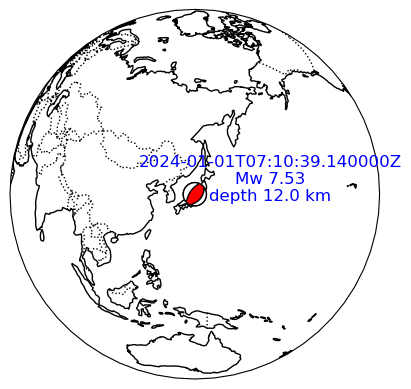

In [2]:
# event name
eqname = "C202401010710A"
# file path to the downloaded event
cmt_filename = "CMTs/{}".format(eqname)
# read the event
cat = obspy.read_events(cmt_filename)

# plot
ortho = ccrs.Orthographic(central_longitude=cat[0].origins[0].longitude, central_latitude=cat[0].origins[0].latitude)
geo = ccrs.Geodetic()

ax = plt.axes(projection=ortho)

ax.coastlines(resolution='110m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_global()

# event position
xy = [cat[0].origins[0].longitude, cat[0].origins[0].latitude]
# transform to map coordinates
xy = geo.transform_point(xy[0], xy[1], src_crs=geo)
# plot focal mechanism
_mt = cat[0].focal_mechanisms[0].moment_tensor.tensor
mt = [_mt.m_rr, _mt.m_tt, _mt.m_pp, _mt.m_rt, _mt.m_rp, _mt.m_tp]
bb = beach(mt, linewidth=1.0, xy=xy,  facecolor='red', edgecolor='black', width=800000)
ax.add_collection(bb)

# add text magnitude number, event name, datetime
plt.text(xy[0]*19000, xy[1]*14000,
         "{}\nMw {}\ndepth {} km".format(cat[0].origins[0].time,
                                   cat[0].magnitudes[0].mag,
                                   cat[0].origins[0].depth/1000),
         fontsize=12, ha='center', va='center', color='blue')

plt.show()

## Downloading Observed Seismic Data

We can also download seismic recordings and instrumentation information using obspy.

In [3]:
# download waveform data from IRIS

def download_data(eqname, t0, min_length=180, stations="*"):
    domain = GlobalDomain()

    restrictions = Restrictions(
        # Get data for a whole year.
        starttime=t0,
        endtime=t0+60*min_length,
        # Chunk it to have one file per day.
        chunklength_in_sec=86400,
        # Considering the enormous amount of data associated with continuous
        # requests, you might want to limit the data based on SEED identifiers.
        # If the location code is specified, the location priority list is not
        # used; the same is true for the channel argument and priority list.
        network="*", station=stations, location="00", channel="BH*",
        # The typical use case for such a data set are noise correlations where
        # gaps are dealt with at a later stage.
        reject_channels_with_gaps=True,
        # Same is true with the minimum length. All data might be useful.
        minimum_length=0.0,
        # Guard against the same station having different names.
        minimum_interstation_distance_in_m=100.0)

    # create directories to store the data
    waveform_dir = "data/{}/waveforms".format(eqname)
    stationxml_dir = "data/{}/stations".format(eqname)
    os.makedirs(waveform_dir, exist_ok=True)
    os.makedirs(stationxml_dir, exist_ok=True)

    mdl = MassDownloader(providers=["IRIS"])
    mdl.download(domain, restrictions,
                 mseed_storage=waveform_dir,
                 stationxml_storage=stationxml_dir)



# target station names
stations = "BORK,TARA"

# get the origin time of the event|
event = cat[0]
origin = event.origins[0]

# download data (skipped if already downloaded)
download_data(eqname, origin.time-30, min_length=30, stations=stations)


[2024-05-15 10:58:00,762] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for IRIS.
[2024-05-15 10:58:02,112] - obspy.clients.fdsn.mass_downloader - INFO: Successfully initialized 1 client(s): IRIS.
[2024-05-15 10:58:02,113] - obspy.clients.fdsn.mass_downloader - INFO: Total acquired or preexisting stations: 0
[2024-05-15 10:58:02,114] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Requesting reliable availability.
[2024-05-15 10:58:02,240] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Successfully requested availability (0.12 seconds)
[2024-05-15 10:58:02,242] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Found 2 stations (6 channels).
[2024-05-15 10:58:02,243] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Will attempt to download data from 2 stations.
[2024-05-15 10:58:02,245] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Status for 6 time intervals/channels before downloading: EXISTS
[

## Indicate the station information 

Station information files are downloaded with the waveform data in `data/station/*.xml`. We can use the `obspy` package to read the station information.



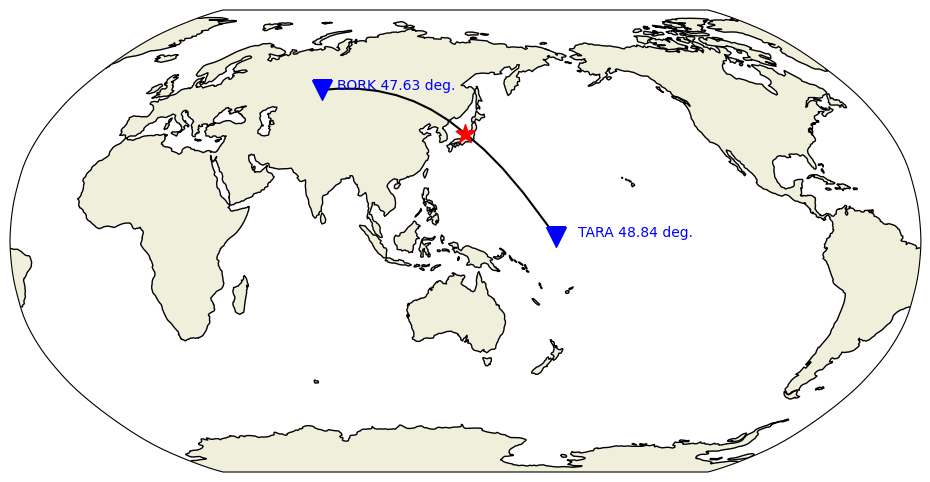

In [4]:
# plot stations on a map

# load the waveform data
obsd_filename_1 = "./data/C202401010710A/waveforms/II.BORK.00.BHZ*.mseed"
obsd_1 = obspy.read(obsd_filename_1)[0]
obsd_filename_2 = "./data/C202401010710A/waveforms/IU.TARA.00.BHZ*.mseed"
obsd_2 = obspy.read(obsd_filename_2)[0]

# load the station information
inv_1 = obspy.read_inventory("./data/C202401010710A/stations/II.BORK.xml")
sta_coord_1 = inv_1.get_coordinates(obsd_1.id)
inv_2 = obspy.read_inventory("./data/C202401010710A/stations/IU.TARA.xml")
sta_coord_2 = inv_2.get_coordinates(obsd_2.id)

fig, ax = plt.subplots(figsize=(12, 6), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=origin.longitude)))
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.LAND)

# epicentral distance
dist_bork = locations2degrees(origin.latitude, origin.longitude, sta_coord_1["latitude"], sta_coord_1["longitude"])
dist_tara = locations2degrees(origin.latitude, origin.longitude, sta_coord_2["latitude"], sta_coord_2["longitude"])

ax.scatter(origin.longitude, origin.latitude, 200, marker="*", color="red", transform=ccrs.PlateCarree(), zorder=100)
ax.scatter(sta_coord_1["longitude"], sta_coord_1["latitude"], 200, marker="v", color="blue", transform=ccrs.PlateCarree(), zorder=100)
ax.text(sta_coord_1["longitude"]*1.1, sta_coord_1["latitude"], f"BORK {dist_bork:5.2f} deg.", color="blue", transform=ccrs.PlateCarree(), zorder=100)
ax.scatter(sta_coord_2["longitude"], sta_coord_2["latitude"], 200, marker="v", color="blue", transform=ccrs.PlateCarree(), zorder=100)
ax.text(sta_coord_2["longitude"]*1.05, sta_coord_2["latitude"], f"TARA {dist_tara:5.2f} deg.", color="blue", transform=ccrs.PlateCarree(), zorder=100)


ax.plot([origin.longitude, sta_coord_1["longitude"]], [origin.latitude, sta_coord_1["latitude"]], "k", transform=ccrs.Geodetic());
ax.plot([origin.longitude, sta_coord_2["longitude"]], [origin.latitude, sta_coord_2["latitude"]], "k", transform=ccrs.Geodetic());



## Forward Modeling using SPECFEM3D_GLOBE
<style>
r { color: Red }
o { color: Orange }
g { color: Green }
b { color: Blue }
bold { font-weight: bold }
</style>


### Initial file structure

The <bold>initial file structure</bold> of the simulation directory is as follows:

``` text
simulation
├─ DATA
|  ├─ CMTSOLUTION
|  ├─ STATIONS
|  └─ Par_file
| 
├─ DATABASES_MPI (empty)
├─ OUTPUT_FILES (empty)
```

In [5]:
# prepare cmt solution (convert from quakeml to CMTSOLUTION)
event.write("./simulation/DATA/CMTSOLUTION", format="CMTSOLUTION")

# prepare STATIONS file for SPECFEM3D_GLOBE
# columns: station_name Network_name latitude longitude elevation burial
with open("./simulation/DATA/STATIONS", "w") as f:
    f.write(f'BORK II {sta_coord_1["latitude"]} {sta_coord_1["longitude"]} {sta_coord_1["elevation"]} {0.0} \n')
    f.write(f'TARA IU {sta_coord_2["latitude"]} {sta_coord_2["longitude"]} {sta_coord_2["elevation"]} {0.0} \n')

# create DATABASES_MPI and OUTPUT_FILES directories
os.makedirs("./simulation/DATABASES_MPI", exist_ok=True)
os.makedirs("./simulation/OUTPUT_FILES", exist_ok=True)

In [26]:
# this cell takes about 7 minutes to run

# load tacc-apptainer module (Singularity)
!module load tacc-apptainer

# change directory to the simulation directory
%cd ./simulation

# change the simulation length to 30 minutes (in DATA/Par_file)
!sed -i 's/RECORD_LENGTH_IN_MINUTES\s*=.*$/RECORD_LENGTH_IN_MINUTES = 30.0d0/' DATA/Par_file

# copy the model files from the container to the host directory
!apptainer exec ../specfem3d_globe_centos7_mpi.sif cp -r /home/scoped/specfem3d_globe/DATA/{crust2.0,s20rts,s40rts,topo_bathy} ./DATA/

# change the simulation setup for a forward simulation
!apptainer run ../specfem3d_globe_centos7_mpi.sif /home/scoped/specfem3d_globe/utils/change_simulation_type.pl -F

# run mesher
!ibrun apptainer run ../specfem3d_globe_centos7_mpi.sif xmeshfem3D

# run solver
!ibrun apptainer run ../specfem3d_globe_centos7_mpi.sif xspecfem3D

# change directory back to the original directory
%cd ..

/bin/bash: line 1: module: command not found
/home/ubuntu/workspace/MINES/ishikawa20240101/workshop_scoped_2024/simulation
/bin/bash: line 1: apptainer: command not found
/bin/bash: line 1: apptainer: command not found
/bin/bash: line 1: ibrun: command not found
/bin/bash: line 1: ibrun: command not found
/home/ubuntu/workspace/MINES/ishikawa20240101/workshop_scoped_2024



### Status check of the running simulation

To check the status of the running simulation, we can use the following command:

``` bash
tail -n40 OUTPUT_FILES/output_solver.txt
```

### File structure after simulation

After the simulation, the file structure of the simulation directory is as follows:

``` text
simulation
├─ DATA
|  ├─ CMTSOLUTION
|  ├─ STATIONS
|  └─ Par_file
|
├─ DATABASES_MPI
|  ├─ (mesh files)
|  
├─ OUTPUT_FILES
|  ├─ {network_name}.{station_name}.{component}.sem.sac

```

## Comparing the data

In [64]:
# read and plot the raw data
import glob
import obspy

# load the observed waveform data
st_obs = obspy.read("./data/C202401010710A/waveforms/*mseed") # in mseed format

# load the synthetic waveform data with 3D model (with SPECFEM3D_GLOBE)
# use the result from the forward simulation
#st_syn = obspy.read("./simulation/OUTPUT_FILES/*sac") # in sac format
# use the precalculated synthetics with 3D model
st_syn= obspy.read("./data/C202401010710A/waveforms_syn/*sac") # in sac format

# load the 1D synthetic waveform data (with normal mode summation)
st_syn_1d = obspy.read("./shakemov_syn/1d/*sac") # in sac format

In [65]:
# reference time (t=0) is CMT time
origin = cat[0].origins[0]
reftime = origin.time

print(f"Reference time: {reftime}")

Reference time: 2024-01-01T07:10:39.140000Z


In [66]:
# cut synthetics to be a half (11200 pts to 5600 pts)
for tr in st_syn:
    tr.trim(tr.stats.starttime, tr.stats.starttime + int(tr.stats.npts/2.0-1)*tr.stats.delta)

# store the original synthetic trace for a validation purpose
st_syn_orig = st_syn.copy()

## Cutting and Resampling

The downloaded singals are generally cut and resampled for those purposes,
- to reduce the size of the data
- to match the sampling rate and time window of the observed data to the synthetic data

The process for the second purpose is also often done after calculating the adjoint sources,
but in this example, we will do the both at the same time here.

In [67]:
print("Initial state of the observed and synthetic data")
print ("BORK")
for trace in (st_obs+st_syn+st_syn_1d).select(station="BORK", channel="*Z"):
    print(f"{trace.id} sampling rate: {trace.stats.sampling_rate:5.2f} start: {trace.stats.starttime} end: {trace.stats.endtime} npts: {trace.stats.npts}")

print ("TARA")
for trace in (st_obs+st_syn+st_syn_1d).select(station="TARA", channel="*Z"):
    print(f"{trace.id} sampling rate: {trace.stats.sampling_rate:5.2f} start: {trace.stats.starttime} end: {trace.stats.endtime} npts: {trace.stats.npts}")


Initial state of the observed and synthetic data
BORK
II.BORK.00.BHZ sampling rate: 40.00 start: 2024-01-01T07:10:09.144538Z end: 2024-01-01T07:40:09.119538Z npts: 72000
II.BORK.S3.MXZ sampling rate:  7.14 start: 2024-01-01T07:10:17.840001Z end: 2024-01-01T07:23:21.700008Z npts: 5600
II.BORK.S1.LXZ sampling rate:  0.50 start: 2024-01-01T07:10:39.100000Z end: 2024-01-01T10:30:37.100000Z npts: 6000
TARA
IU.TARA.00.BHZ sampling rate: 40.00 start: 2024-01-01T07:10:09.144539Z end: 2024-01-01T07:40:09.119539Z npts: 72000
IU.TARA.S3.MXZ sampling rate:  7.14 start: 2024-01-01T07:10:17.840001Z end: 2024-01-01T07:23:21.700008Z npts: 5600
IU.TARA.S1.LXZ sampling rate:  0.50 start: 2024-01-01T07:10:39.100000Z end: 2024-01-01T10:30:37.100000Z npts: 6000


In [68]:
# adjust the time window and resample the data
sampling_rate = st_syn[0].stats.sampling_rate

start_bork = np.max([st_obs.select(station="BORK", channel="*Z")[0].stats.starttime,
                     st_syn.select(station="BORK", channel="*Z")[0].stats.starttime]) #+ 100
end_bork   = np.min([st_obs.select(station="BORK", channel="*Z")[0].stats.endtime,
                    st_syn.select(station="BORK", channel="*Z")[0].stats.endtime]) #- 50
npts_bork = st_syn.select(station="BORK", channel="*Z")[0].stats.npts

for trace in (st_obs+st_syn).select(station="BORK"):
    trace.interpolate(sampling_rate=sampling_rate, starttime=start_bork, npts=npts_bork)

# fix the time window for 1D synthetics only for comparison
st_syn_1d.select(station="BORK").trim(starttime=start_bork, endtime=end_bork, pad=False)

print("BORK after resampling")
for trace in (st_obs+st_syn+st_syn_1d).select(station="BORK", channel="*Z"):
    print(f"{trace.id} sampling rate: {trace.stats.sampling_rate:5.2f} start: {trace.stats.starttime} end: {trace.stats.endtime} npts: {trace.stats.npts}")

start_tara = np.max([st_obs.select(station="TARA", channel="*Z")[0].stats.starttime,
                     st_syn.select(station="TARA", channel="*Z")[0].stats.starttime])
end_tara   = np.min([st_obs.select(station="TARA", channel="*Z")[0].stats.endtime,
                     st_syn.select(station="TARA", channel="*Z")[0].stats.endtime])
npts_tara = st_syn.select(station="TARA", channel="*Z")[0].stats.npts

for trace in (st_obs+st_syn).select(station="TARA"):
    trace.interpolate(sampling_rate=sampling_rate, starttime=start_tara, npts=npts_tara)

# fix the time window for 1D synthetics only for comparison
st_syn_1d.select(station="tara").trim(starttime=start_tara, endtime=end_tara, pad=False)

print("TARA after resampling")
for trace in (st_obs+st_syn+st_syn_1d).select(station="TARA", channel="*Z"):
    print(f"{trace.id} sampling rate: {trace.stats.sampling_rate:5.2f} start: {trace.stats.starttime} end: {trace.stats.endtime} npts: {trace.stats.npts}")



BORK after resampling
II.BORK.00.BHZ sampling rate:  7.14 start: 2024-01-01T07:10:17.840001Z end: 2024-01-01T07:23:21.700008Z npts: 5600
II.BORK.S3.MXZ sampling rate:  7.14 start: 2024-01-01T07:10:17.840001Z end: 2024-01-01T07:23:21.700008Z npts: 5600
II.BORK.S1.LXZ sampling rate:  0.50 start: 2024-01-01T07:10:39.100000Z end: 2024-01-01T07:23:21.100000Z npts: 382
TARA after resampling
IU.TARA.00.BHZ sampling rate:  7.14 start: 2024-01-01T07:10:17.840001Z end: 2024-01-01T07:23:21.700008Z npts: 5600
IU.TARA.S3.MXZ sampling rate:  7.14 start: 2024-01-01T07:10:17.840001Z end: 2024-01-01T07:23:21.700008Z npts: 5600
IU.TARA.S1.LXZ sampling rate:  0.50 start: 2024-01-01T07:10:39.100000Z end: 2024-01-01T07:23:21.100000Z npts: 382


## Filtering and Removing Instrument Response

Observed data:

$$
obsd = \text{source} * \text{model} * \text{instrument}
$$

Synthetic data:

$$
synt = \text{source} * \text{model}
$$

In order to compare the data, we need to deconvolve the instrument response from observed data and filter both data to a comparable frequency range.

We downloaded *StationXML* files with the seismic data. These files contain information about stations like location and response function. We can use this information to remove the instrument response.

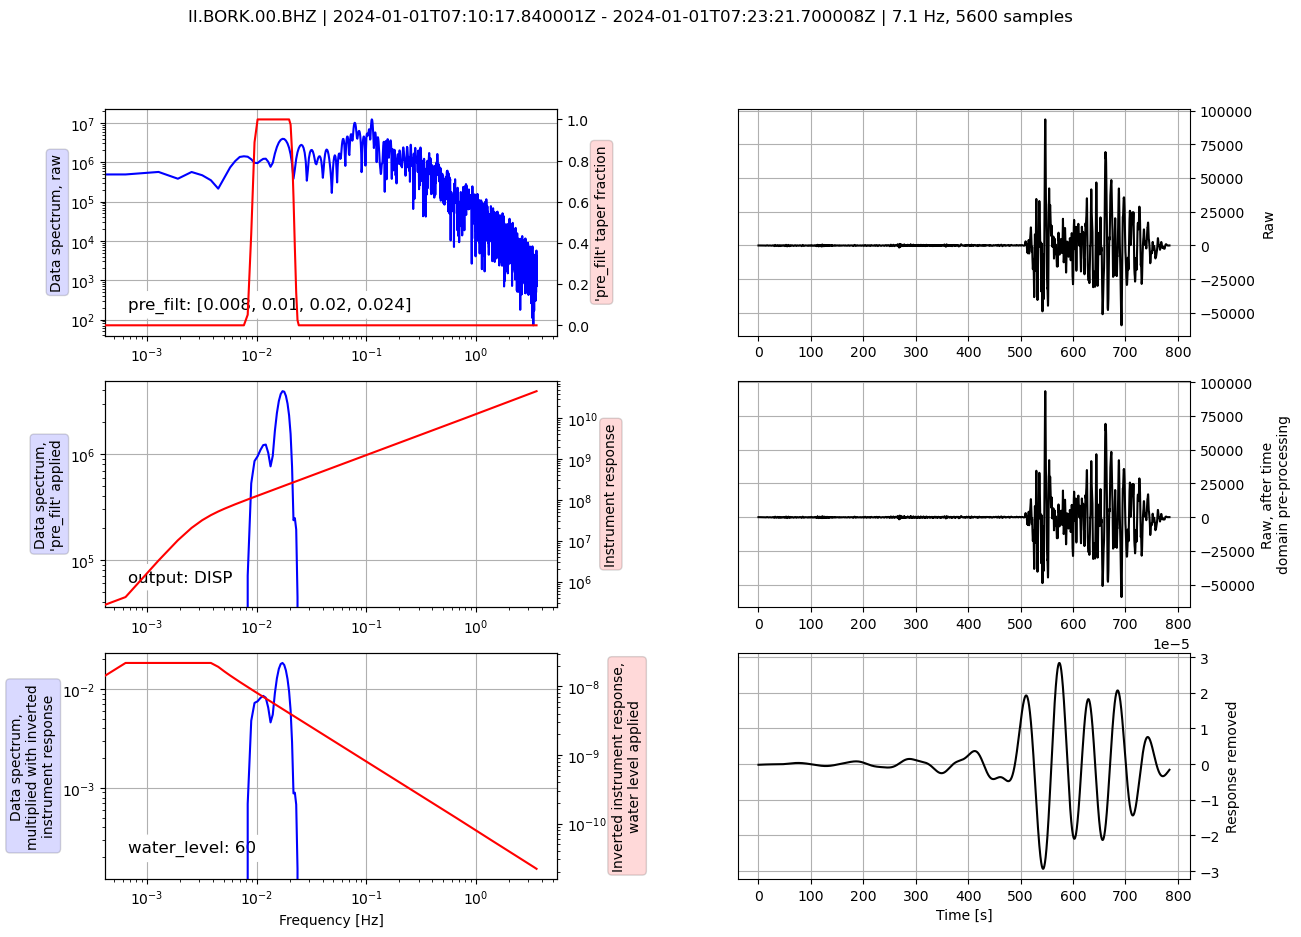

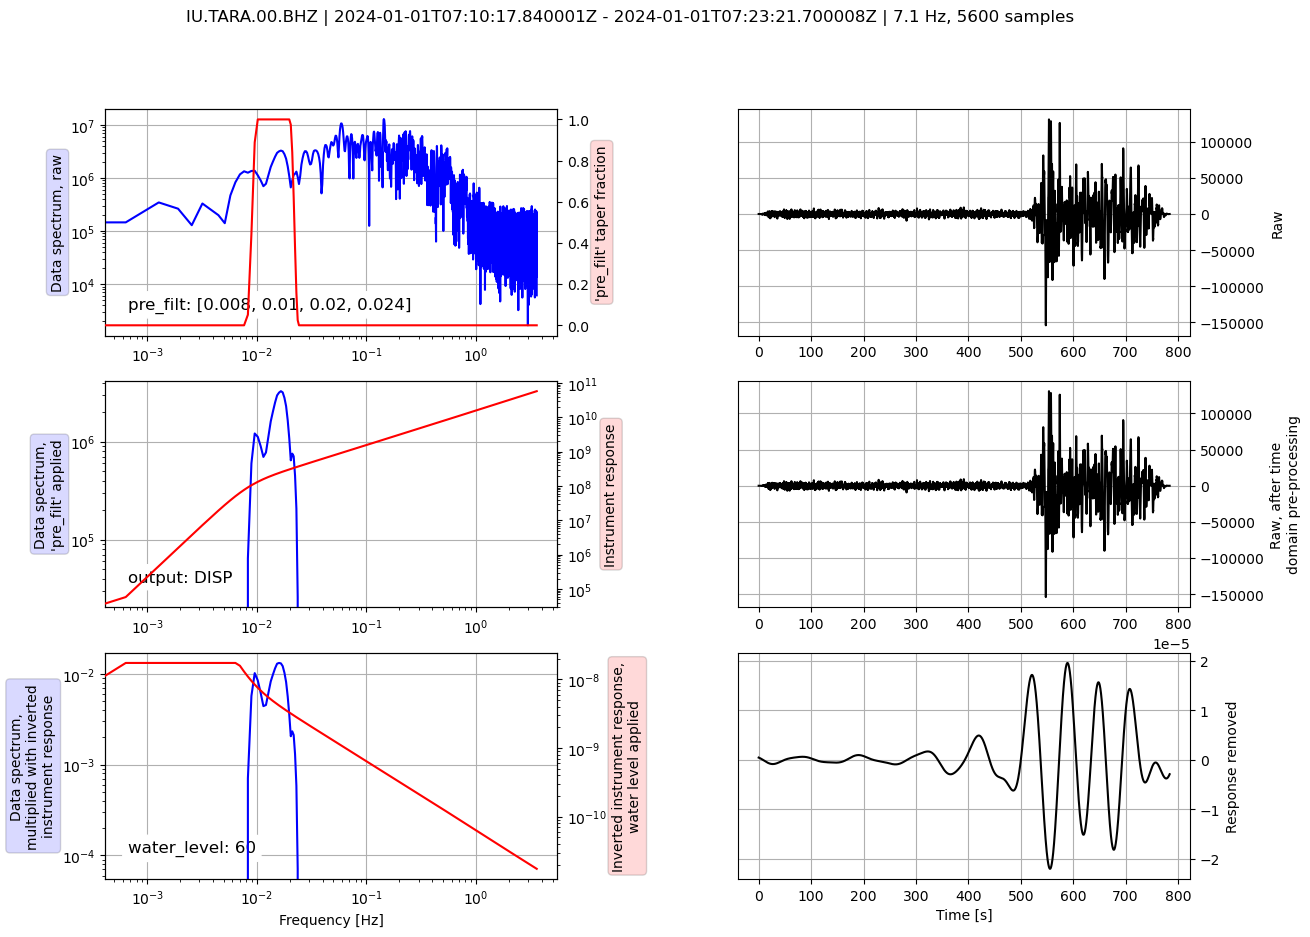

In [69]:
# Reading the instrument data

# frequency band for the bandpass filter
min_period = 50
max_period = 100
freqmin = 1.0/max_period
freqmax = 1.0/min_period
pre_filt = (0.8*freqmin, freqmin, freqmax, 1.2*freqmax)

# directory path to the instrument response files
dir_path_inv = f"./data/{eqname}/stations"

# process the observed data by each trace
for tr in st_obs:
    network = tr.stats.network
    station = tr.stats.station
    channel = tr.stats.channel
    # read the instrument response file
    inv = obspy.read_inventory(f"{dir_path_inv}/{network}.{station}.xml")
    # attach the instrument response to the trace
    tr.attach_response(inv)

    # add coordinates to the trace
    tr.stats.latitude = inv[0][0].latitude
    tr.stats.longitude = inv[0][0].longitude
    tr.stats.elevation = inv[0][0].elevation

    # change channel name from BH1 to BHN, BH2 to BHE (only for rotation with obspy)
    if tr.stats.channel == "BH1":
        tr.stats.channel = "BHN"
    elif tr.stats.channel == "BH2":
        tr.stats.channel = "BHE"

    # remove mean and linear trend
    tr.detrend("demean")
    tr.detrend("linear")
    # taper
    tr.taper(max_percentage=0.05, type="cosine")

    # plot the result if the trace is vertical
    if tr.stats.channel[-1] == "Z":
        plot = True
    else:
        plot = False

    # remove the instrument response with a pre-filter
    tr.remove_response(output="DISP", pre_filt=pre_filt, water_level=60, plot=plot)


In [70]:
# use sac taper on synthetic data

def sac_taper(tr):
    data = tr.data.astype(np.float64)
    nfft = _npts2nfft(len(tr.data))
    data = np.fft.rfft(tr.data, nfft)
    fy = 1.0 / (tr.stats.delta * 2.0)
    freqs = np.linspace(0, fy, nfft//2+1)
    data *= cosine_sac_taper(freqs, flimit=pre_filt)
    data[-1] = abs(data[-1]) + 0.0j
    tr.data = np.fft.irfft(data)[0:len(tr.data)]

st_syn.detrend("linear")
st_syn.detrend("demean")
st_syn.taper(0.05, type="cosine")

for tr in st_syn:
    sac_taper(tr)

# apply the same filter on 1D synthetic data just for comparison
st_syn_1d.detrend("linear")
st_syn_1d.detrend("demean")
st_syn_1d.taper(0.05, type="cosine")

for tr in st_syn_1d:
    sac_taper(tr)

print(st_obs.select(station="BORK",channel="*Z")[0])
print(st_syn.select(station="BORK",channel="*Z")[0])
print(st_syn_1d.select(station="BORK",channel="*Z")[0])

II.BORK.00.BHZ | 2024-01-01T07:10:17.840001Z - 2024-01-01T07:23:21.700008Z | 7.1 Hz, 5600 samples
II.BORK.S3.MXZ | 2024-01-01T07:10:17.840001Z - 2024-01-01T07:23:21.700008Z | 7.1 Hz, 5600 samples
II.BORK.S1.LXZ | 2024-01-01T07:10:39.100000Z - 2024-01-01T07:23:21.100000Z | 0.5 Hz, 382 samples


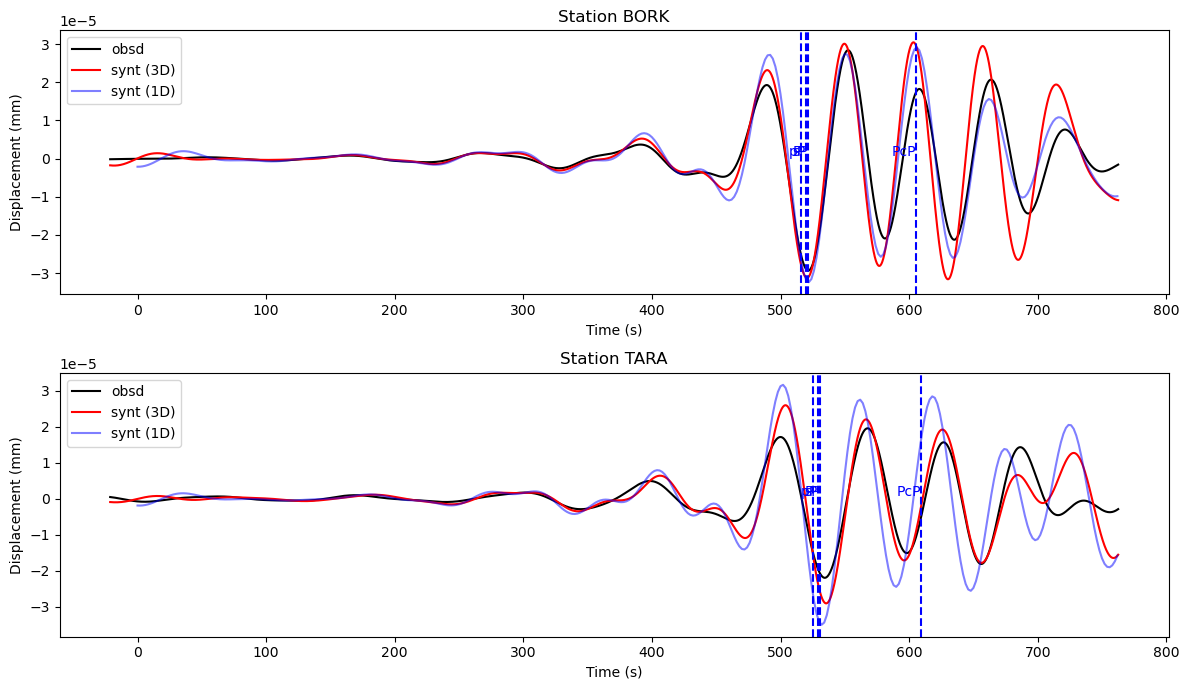

<PolarAxes: >

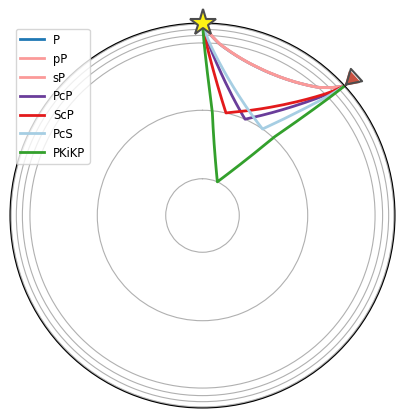

In [71]:
# plot the observed and synthetic data by overlaying them
tr_obs_bork = st_obs.select(station="BORK", channel="*Z")[0]
tr_syn_bork = st_syn.select(station="BORK", channel="*Z")[0]
tr_syn_1d_bork = st_syn_1d.select(station="BORK", channel="*Z")[0]
tr_obs_tara = st_obs.select(station="TARA", channel="*Z")[0]
tr_syn_tara = st_syn.select(station="TARA", channel="*Z")[0]
tr_syn_1d_tara = st_syn_1d.select(station="TARA", channel="*Z")[0]

fig, ax = plt.subplots(2,1 , figsize=(12, 7))
ax[0].plot(tr_obs_bork.times(reftime=reftime),    tr_obs_bork.data, "k", label="obsd")
ax[0].plot(tr_syn_bork.times(reftime=reftime),    tr_syn_bork.data, "r", label="synt (3D)")
ax[0].plot(tr_syn_1d_bork.times(reftime=reftime), tr_syn_1d_bork.data, "b", label="synt (1D)", alpha=0.5)
ax[0].legend(loc=2)
ax[0].set_ylabel("Displacement ({})".format(disp_unit))
ax[0].set_xlabel("Time (s)")
ax[0].set_title("Station BORK")
ax[1].plot(tr_obs_tara.times(reftime=reftime),    tr_obs_tara.data, "k", label="obsd")
ax[1].plot(tr_syn_tara.times(reftime=reftime),    tr_syn_tara.data, "r", label="synt (3D)")
ax[1].plot(tr_syn_1d_tara.times(reftime=reftime), tr_syn_1d_tara.data, "b", label="synt (1D)", alpha=0.5)
ax[1].legend(loc=2)
ax[1].set_ylabel("Displacement ({})".format(disp_unit))
ax[1].set_xlabel("Time (s)")
ax[1].set_title("Station TARA")

#ax[0].set_xlim(400, 700)
#ax[1].set_xlim(400, 700)


# add P- and S-wave arrivals
from obspy.taup import TauPyModel
phase_list=["P", "pP", "sP", "PcP","ScP","PcS","PKiKP"]

model = TauPyModel(model="iasp91")
arrivals_bork = model.get_ray_paths(
    source_depth_in_km=origin.depth/1000,
    distance_in_degree=locations2degrees(origin.latitude, origin.longitude,
                                         tr_syn_bork.stats.sac["stla"], tr_syn_bork.stats.sac["stlo"]),
    phase_list=phase_list)
arrivals_tara = model.get_ray_paths(
    source_depth_in_km=origin.depth/1000,
    distance_in_degree=locations2degrees(origin.latitude, origin.longitude,
                                         tr_syn_tara.stats.sac["stla"], tr_syn_tara.stats.sac["stlo"]),
    phase_list=phase_list)

# draw the arrivals
for arrival in arrivals_bork:
    if origin.time + arrival.time < tr_syn_bork.stats.endtime:
        ax[0].axvline(arrival.time, color="blue", linestyle="--")
        ax[0].text(arrival.time, 0, arrival.name, va="bottom", ha="right", color="blue")

for arrival in arrivals_tara:
    if origin.time + arrival.time < tr_syn_tara.stats.endtime:
        ax[1].axvline(arrival.time, color="blue", linestyle="--")
        ax[1].text(arrival.time, 0, arrival.name, va="bottom", ha="right", color="blue")

plt.tight_layout()
plt.show()

# plot raypath
fig, ax = plt.subplots(subplot_kw=dict(polar=True),figsize=(5,5))

arrivals_bork.plot_rays(plot_type='spherical',
                        label_arrivals=False,
                        legend=True,
                        plot_all=True,
                        show=False,ax=ax)


## Raypaths plotted on S40RTS model
![Raypaths](./img/s40rts_path.png)

## Calculate the misfit and adjoint sources

In [72]:
# preproces
import obspy.geodetics

def preprocess_before_adjoint_source_calculation(st,ev,obs_data=True):
    # perform ENZ to RTZ rotation for the synthetic and observed data

    list_st_names = list(set([tr.stats.station for tr in st]))
    for st_name in list_st_names:
        # calculate the back azimuth
        if obs_data:
            # calculate the back azimuth by using the event and station coordinates
            baz = obspy.geodetics.gps2dist_azimuth(ev.origins[0].latitude,ev.origins[0].longitude,
                                                    st.select(station=st_name)[0].stats.latitude,
                                                    st.select(station=st_name)[0].stats.longitude)[2]
        else:
            # synthetic data contains the back azimuth information
            baz = st.select(station=st_name)[0].stats.sac["baz"]

        st.select(station=st_name).rotate(method="NE->RT", back_azimuth=baz)

# rotate the traces
# observed data
preprocess_before_adjoint_source_calculation(st_obs, event, obs_data=True)
# synthetic data
preprocess_before_adjoint_source_calculation(st_syn, event, obs_data=False)

/tmp/ipykernel_934267/1623462568.py:12: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  baz = obspy.geodetics.gps2dist_azimuth(ev.origins[0].latitude,ev.origins[0].longitude,


In [73]:
import numpy as np
import matplotlib.pyplot as plt

# custom window functions
def window_taper(signal, taper_percentage, taper_type):
    npts = len(signal)
    frac = int(npts * taper_percentage / 2.0 + 0.5)

    idx1 = frac
    idx2 = npts - frac

    if taper_type == "hann":
        window = 0.5 - 0.5 * np.cos(2.0 * np.pi * np.arange(0, 2 * frac) / (2 * frac - 1))
    elif taper_type == "hamming":
        window = 0.54 - 0.46 * np.cos(2.0 * np.pi * np.arange(0, 2 * frac) / (2 * frac - 1))
    elif taper_type == "cos":
        window = np.cos(np.pi * np.arange(0, 2 * frac) / (2 * frac - 1) - np.pi / 2.0)
    elif taper_type == "cos_p10":
        window = 1. - np.cos(np.pi * np.arange(0, 2 * frac) / (2 * frac - 1)) ** 10

    signal[:idx1] *= window[:frac]
    signal[idx2:] *= window[frac:]

    # return test signal
    test = np.ones(npts)
    test[:idx1] = window[:frac]
    test[idx2:] = window[frac:]

    return signal, test


## Varieties of Misfit Functions

Always be careful about the sign of the adjoint sources!!!
### Normalized Waveform Misfit:

Misfit function 
$$
\chi(m) = \frac{1}{2} \sum_{i=1}^{N_r} \frac{\int_0^T [d_i(t) - s_i(t,m)]^2 dt}{\int d_i^2(t) dt} 
$$
Adjoint source for i-th station
$$
f_i^\dagger(t) = \frac{-(d_i(t) - s_i(t,m))}{\int_0^T d_i^2(t) dt} 
$$

### Traveltime Misfit:

Misfit function
$$
\chi = \frac{1}{2} \sum_{i=0}^{N_r} [T^{obs}_{i} - T^{syn}_{i}]^2
$$
Adjoint source for i-th station
$$
f^{\dagger}_i(t) = - \frac{1}{N} ~ \left[ T^{obs}_{i} - T^{syn}_{i} \right] ~ 
\partial_t s_i(t,m),
$$

where 
$$
N = \int_0^T ~ s_i(t,m) ~
\partial^2_t s_i(t,m) dt.
$$

In order to avoid the error introduced by the 2nd order derivative, we apply integration by part and use the following formula:
$$
N =\int_0^T ~ \partial_t s_i(t,m) \partial_t s_i(t,m) dt
$$
then the adjoint source becomes
$$
f^{\dagger}_i(t) = \frac{1}{N} ~ \left[ T^{obs}_{i} - T^{syn}_{i} \right] ~ 
\partial_t s_i(t,m),
$$


### Amplitude Misfit:

Misfit function
$$
\chi = \frac{1}{2} \sum_{i=0}^{N_r} \left[ \ln \left( \frac{A^{obs}_i}{A^{syn}_i(m)} \right) \right]^2
$$
Adjoint source for i-th station
$$
f^{\dagger}_i(t) = - \frac{1}{M_i} ~ \left[ \ln \left( \frac{A^{obs}_i}{A^{syn}_i(m)} \right) \right] s_i(t),
$$

where
$$
M_i = \int_0^T s_i^2(t,m)dt
$$





In [102]:
from scipy.integrate import simpson

# available adjoint source types
available_adjtype = ['waveform', 'traveltime', 'amplitude']

# cross-correlation function to calculate the time shift
def xcorr_shift(d, s):
    cc = np.correlate(d, s, mode="full")
    time_shift = cc.argmax() - len(d) + 1
    return time_shift

# function to calculate adjoint source
def calculate_adjoint_source(_tr_obs, _tr_syn, origin, tmin, tmax,
                             plot=False, plot_only_adj=False, adjtype='waveform', taper_percentage=0.3, win_type='cos_p10'):
    """
    Calculate adjoint source
    tmin and tmax are the window range in seconds for the adjoint source calculation, starting from the first data point of the trace
    """

    if adjtype not in available_adjtype:
        print(f"adjtype {adjtype} is not available. Please choose from {available_adjtype}")
        return None

    # copy the observed and synthetic data
    tr_obs = _tr_obs.copy()
    tr_syn = _tr_syn.copy()

    # event time (CMT time)
    event_time = origin.time

    # window for the adjoint source calculation
    tr_obs.trim(starttime=event_time+tmin, endtime=event_time+tmax)
    tr_syn.trim(starttime=event_time+tmin, endtime=event_time+tmax)
    tr_obs.data, _ = window_taper(tr_obs.data, taper_percentage, win_type)
    tr_syn.data, _ = window_taper(tr_syn.data, taper_percentage, win_type)

    # check if the observed and synthetic data have the same data length and sampling rate
    if tr_obs.stats.npts != tr_syn.stats.npts:
        print(f"Observed and synthetic data have different data length: {tr_obs.stats.npts} and {tr_syn.stats.npts}")
        return None

    if tr_obs.stats.sampling_rate != tr_syn.stats.sampling_rate:
        print(f"Observed and synthetic data have different sampling rate: {tr_obs.stats.sampling_rate} and {tr_syn.stats.sampling_rate}")
        return None

    # calculate adjoint source
    s, e = st_syn_orig[0].stats.starttime, st_syn_orig[0].stats.endtime
    tr_adj = tr_syn.copy()

    if adjtype == 'waveform':
        # calculate the misfit function
        misfit = 0.5*simpson((tr_obs.data - tr_syn.data) ** 2, dx=tr_obs.stats.delta)

        # normalization factor
        norm_w = simpson(tr_obs.data**2, dx=tr_obs.stats.delta)

        # calculate the adjoint source = - factor*(observed - synthetic)
        tr_adj.data = - (tr_obs.data - tr_syn.data) / norm_w

    elif adjtype == 'traveltime':
        # calculate time shift and amplitude anomaly by cross-correlation
        ishift = xcorr_shift(tr_obs.data, tr_syn.data)
        tshift = ishift * tr_syn.stats.delta

        # misfit function for the time shift and amplitude anomaly
        misfit = 0.5 * tshift**2

        # calculate the derivative of the current displacement
        _v = np.gradient(tr_syn.data, tr_syn.stats.delta)

        # normalization factor
        norm_t = simpson(_v**2, dx=tr_syn.stats.delta)

        # calculate traveltime adjoint source
        tr_adj.data = tshift * _v / norm_t

    elif adjtype == 'amplitude':
        # calculate amplitude ratio by cross-correlation
        ishift = xcorr_shift(tr_obs.data, tr_syn.data)

        # shift the synthetic data and keep the length
        tr_syn.data = np.roll(tr_syn.data, -ishift)

        # amplitude ratio
        amp_ratio = np.sum(tr_obs.data*tr_syn.data) / np.sum(tr_syn.data**2)

        # misfit
        misfit = 0.5 * (np.log(amp_ratio) ** 2)

        # normalization factor
        norm_a = simpson(tr_syn.data**2, dx=tr_syn.stats.delta)

        # calculate amplitude adjoint source
        tr_adj.data = -1.0 * np.log(amp_ratio) * tr_syn.data / norm_a

    # apply the same filter as the synthetic data
    tr_adj.detrend("linear")
    tr_adj.detrend("demean")
    tr_adj.taper(0.05, type="cosine")
    sac_taper(tr_adj)
    # taper the adjoint source
    tr_adj.data, wtest = window_taper(tr_adj.data, taper_percentage, win_type)
    # zero padding
    tr_adj.trim(starttime=s, endtime=e, pad=True, fill_value=0.0)

    # check the data compatibility
    if tr_adj.stats.npts != st_syn_orig[0].stats.npts:
        print(f"Adjoint source has different data length: {tr_adj.stats.npts} and synthetic {st_syn_orig[0].stats.npts}")
        return None
    if tr_adj.stats.sampling_rate != st_syn_orig[0].stats.sampling_rate:
        print(f"Adjoint source has different sampling rate: {tr_adj.stats.sampling_rate} and synthetic {st_syn_orig[0].stats.sampling_rate}")
        return None

    if plot:
        # copy traces for plotting
        tr_obs_plot = _tr_obs.copy()
        tr_syn_plot = _tr_syn.copy()

        # start time of the traces is different
        tr_st_diff_obs = tr_obs_plot.stats.starttime - event_time
        tr_st_diff_syn = tr_syn_plot.stats.starttime - event_time

        # mergin for xlimit
        #xmin = tmin*0.8
        #xmax = tmax*1.2
        xmin = np.max([(tr_adj.times(reftime=event_time)[0]+tmin)*0.8, tr_adj.times(reftime=event_time)[0]])
        xmax = np.min([(tr_adj.times(reftime=event_time)[0]+tmax)*1.2, tr_adj.times(reftime=event_time)[-1]])

        # take max and min of the data in xrange
        vmin = min(tr_obs_plot.data[(tr_obs_plot.times() > xmin) & (tr_obs_plot.times() < xmax)].min(),
                   tr_syn_plot.data[(tr_syn_plot.times() > xmin) & (tr_syn_plot.times() < xmax)].min())*1.3
        vmax = max(tr_obs_plot.data[(tr_obs_plot.times() > xmin) & (tr_obs_plot.times() < xmax)].max(),
                   tr_syn_plot.data[(tr_syn_plot.times() > xmin) & (tr_syn_plot.times() < xmax)].max())*1.3

        # check vmin and vmax between xmin and xmax for entire signal
        vmin_whole = min(tr_obs_plot.data.min(), tr_syn_plot.data.min())*1.3
        vmax_whole = max(tr_obs_plot.data.max(), tr_syn_plot.data.max())*1.3

        # check vmin and vmax between xmin and xmax for adjoint source
        vmin_adj = tr_adj.data.min()*1.3
        vmax_adj = tr_adj.data.max()*1.3

        if not plot_only_adj:
            # plot tr_obs and tr_syn on axs[0] (whole signal), axs[1] (around the window), then plot tr_adj on axs[2]
            fig, axs = plt.subplots(3, 1, figsize=(10, 6), sharex=False)

            axs[0].plot(tr_obs_plot.times(reftime=event_time), tr_obs_plot.data, 'k', label='Observed')
            axs[0].plot(tr_syn_plot.times(reftime=event_time), tr_syn_plot.data, 'r', label='Synthetic')
            axs[0].set_title(f"Station (obs) {tr_obs.stats.station} {tr_obs.stats.channel} - (syn) {tr_syn.stats.station} {tr_syn.stats.channel}")
            axs[0].set_xlabel('Time (s)')
            axs[0].set_ylabel(f'Displacement ({disp_unit})')
            axs[0].legend()

            axs[1].plot(tr_obs_plot.times(reftime=event_time), tr_obs_plot.data, 'k', label='Observed')
            axs[1].plot(tr_syn_plot.times(reftime=event_time), tr_syn_plot.data, 'r', label='Synthetic')
            axs[1].set_title(f"Station (obs) {tr_obs.stats.station} {tr_obs.stats.channel} - (syn) {tr_syn.stats.station} {tr_syn.stats.channel}")
            axs[1].set_xlabel('Time (s)')
            axs[1].set_ylabel(f'Displacement ({disp_unit})')
            axs[1].legend()

            axs[2].plot(tr_adj.times(reftime=event_time), tr_adj.data, 'k', label='Adjoint source')
            axs[2].set_title(f"Adjoint source, type: {adjtype}, misfit: {misfit:.4e}")
            axs[2].set_xlabel('Time (s)')
            #axs[2].set_ylabel(f'Displacement ({disp_unit})')
            #axs[2].legend()

            axs[0].set_xlim(tr_adj.times(reftime=event_time)[0], tr_adj.times(reftime=event_time)[-1])
            axs[1].set_xlim(xmin, xmax)
            axs[2].set_xlim(xmin, xmax)

            axs[1].set_ylim(vmin, vmax)

            # vertical lines for the taper region
            for i in range(3):
                axs[i].axvline(tmin, color='grey', linestyle='--')
                axs[i].axvline(tmax, color='grey', linestyle='--', label='Taper region')

            # change background color for the taper region with wtest_obs value
            x, y = np.meshgrid(np.linspace(tmin,tmax,100), np.linspace(vmin, vmax,100))
            for i in range(3):
                if i == 0:
                    extent = [tmin, tmax, vmin_whole, vmax_whole]
                elif i == 1:
                    extent = [tmin, tmax, vmin, vmax]
                else:
                    extent = [tmin, tmax, vmin_adj, vmax_adj]
                # z from wtime_obs
                axs[i].imshow(wtest.reshape(1,-1), extent=extent, aspect='auto', cmap='Greys', alpha=0.3)

            # plot arrival time
            if trace.stats.station == "BORK":
                arrivals = arrivals_bork
            elif trace.stats.station == "TARA":
                arrivals = arrivals_tara

            if trace.stats.station in ["BORK", "TARA"]:
                for arrival in arrivals:
                    if arrival.time < xmax and arrival.time > xmin:
                        axs[1].axvline(arrival.time, color="blue", linestyle="--")
                        axs[1].text(arrival.time, 0, arrival.name, va="bottom", ha="right", color="blue")


        else: # plot only adjoint source
            fig, ax = plt.subplots(1, 1, figsize=(10, 2))
            ax.plot(tr_adj.times(reftime=event_time), tr_adj.data, 'k', label='Adjoint source')
            ax.set_title(f"Adjoint source, type: {adjtype}, misfit: {misfit:.4e}")
            ax.set_xlabel('Time (s)')
            #ax.set_ylabel(f'Displacement ({disp_unit})')
            #ax.legend()

            ax.set_xlim(xmin, xmax)
            ax.set_ylim(vmin_adj, vmax_adj)
            ax.axvline(tmin, color='grey', linestyle='--')
            ax.axvline(tmax, color='grey', linestyle='--', label='Taper region')
            # change background color for the taper region with wtest_obs value
            x, y = np.meshgrid(np.linspace(tmin,tmax,100), np.linspace(vmin_adj, vmax_adj,100))
            extent = [tmin, tmax, vmin_adj, vmax_adj]
            # z from wtime_obs
            ax.imshow(wtest.reshape(1,-1), extent=extent, aspect='auto', cmap='Greys', alpha=0.3)

        plt.tight_layout()
        plt.show()

    return tr_adj, misfit


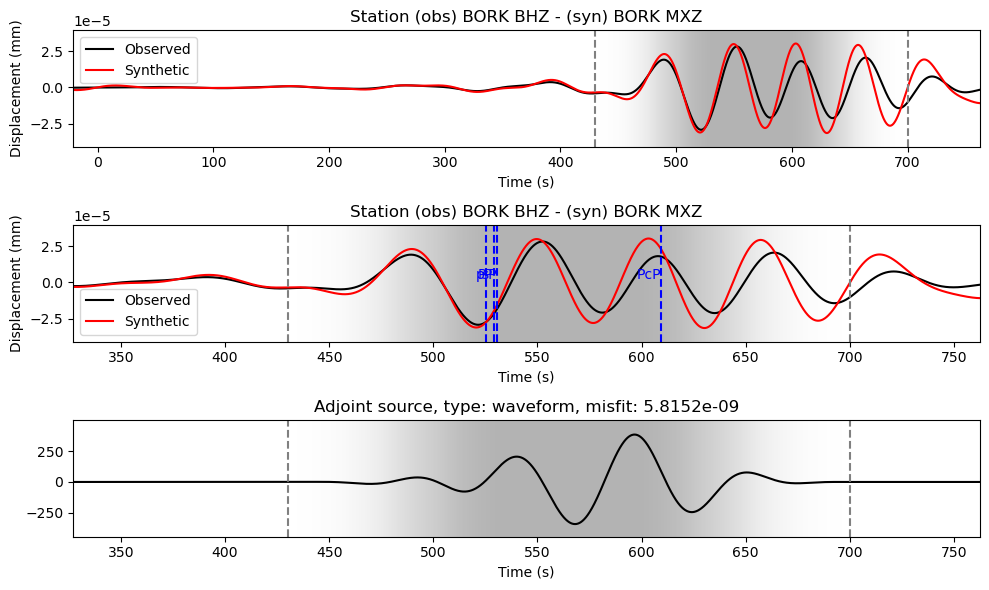

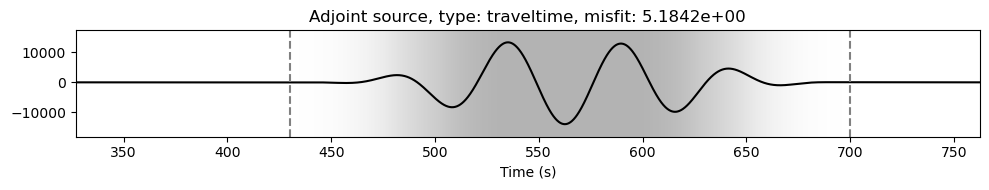

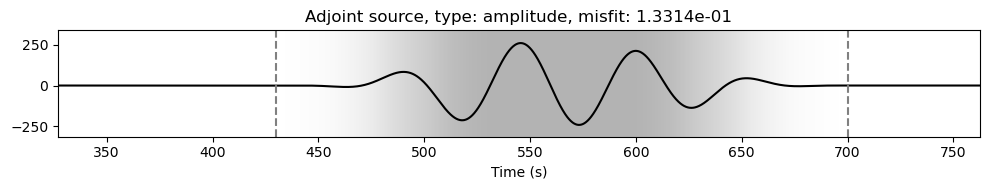

In [103]:
# calculate adjoint source for 'BORK' station
test_tr_syn = st_syn.select(station='BORK', channel='MXZ')[0].copy()
test_tr_obs = st_obs.select(station='BORK', channel='BHZ')[0].copy()

twin_BORK = [430, 700]
taper_percentage_BORK=0.8 # window length * taper_percentage / 2 is the taper length of the initial and final part of the window
win_type='hann'
_, _ = calculate_adjoint_source(test_tr_obs, test_tr_syn, origin, twin_BORK[0], twin_BORK[1], plot=True, adjtype='waveform',   taper_percentage=taper_percentage_BORK, win_type=win_type)
_, _ = calculate_adjoint_source(test_tr_obs, test_tr_syn, origin, twin_BORK[0], twin_BORK[1], plot=True, adjtype='traveltime', taper_percentage=taper_percentage_BORK, win_type=win_type, plot_only_adj=True)
_, _ = calculate_adjoint_source(test_tr_obs, test_tr_syn, origin, twin_BORK[0], twin_BORK[1], plot=True, adjtype='amplitude',  taper_percentage=taper_percentage_BORK, win_type=win_type, plot_only_adj=True)

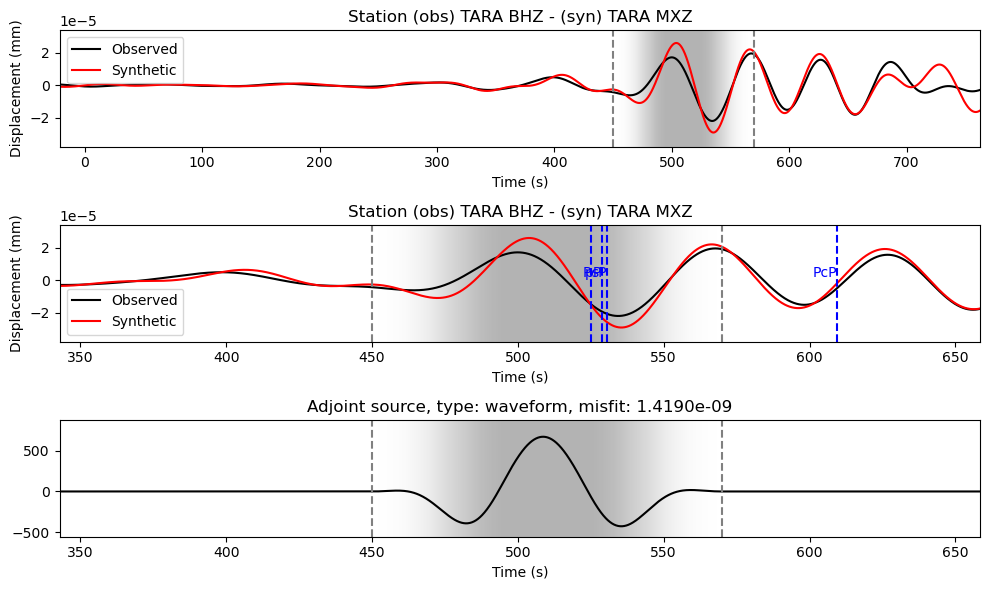

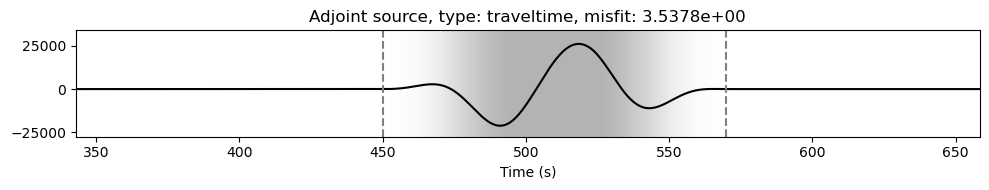

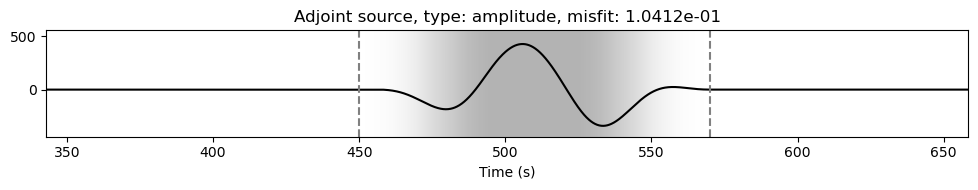

In [104]:
# for TARA station
test_tr_syn = st_syn.select(station='TARA', channel='MXZ')[0].copy()
test_tr_obs = st_obs.select(station='TARA', channel='BHZ')[0].copy()

twin_TARA = [450, 570]
taper_percentage_TARA=0.8 # window length * taper_percentage / 2 is the taper length of the initial and final part of the window
win_type='hann'
_, _ = calculate_adjoint_source(test_tr_obs, test_tr_syn, origin, twin_TARA[0], twin_TARA[1], plot=True, adjtype='waveform',   taper_percentage=taper_percentage_TARA, win_type=win_type)
_, _ = calculate_adjoint_source(test_tr_obs, test_tr_syn, origin, twin_TARA[0], twin_TARA[1], plot=True, adjtype='traveltime', taper_percentage=taper_percentage_TARA, win_type=win_type, plot_only_adj=True)
_, _ = calculate_adjoint_source(test_tr_obs, test_tr_syn, origin, twin_TARA[0], twin_TARA[1], plot=True, adjtype='amplitude',  taper_percentage=taper_percentage_TARA, win_type=win_type, plot_only_adj=True)

In [105]:
import obspy
channel_list = ['*Z', '*R', '*T'] # BHZ, BHR, BHT in the observed data and MXZ, MXR, MXT in the synthetic data


def calculate_adjoint_source_all_components(st_obs, st_syn, origin, tmin, tmax, plot=False, adjtype='traveltime',
                                            taper_percentage=0.6, win_type='hann',ch='all'):
    """
    Calculate adjoint source for all the three components
    """

    # initialize adjoint source
    st_adj = obspy.Stream()

    # calculate adjoint source for each component
    if ch=='all':
        for channel in channel_list:
            tr_obs = st_obs.select(channel=channel)[0]
            tr_syn = st_syn.select(channel=channel)[0]

            tr_adj, misfit = calculate_adjoint_source(tr_obs, tr_syn, origin, tmin, tmax, plot=plot, adjtype=adjtype,
                                                      taper_percentage=taper_percentage, win_type=win_type)

            # append the adjoint source to the stream
            st_adj += tr_adj
    elif ch not in channel_list:
         print("Error: Channel not in list")
    else:
        for channel in channel_list:
            if channel==ch:
                print ("calculating ch ", channel)
                tr_obs = st_obs.select(channel=channel)[0]
                tr_syn = st_syn.select(channel=channel)[0]

                tr_adj, misfit = calculate_adjoint_source(tr_obs, tr_syn, origin, tmin, tmax, plot=plot, adjtype=adjtype,
                                                              taper_percentage=taper_percentage, win_type=win_type)
                st_adj+=tr_adj

            else:
                print("zero trace for channel ", channel)
                tr_syn = st_syn.select(channel=channel)[0]
                tr_adj = tr_syn.copy()
                tr_adj.data = np.zeros(len(tr_adj.data))
                st_adj+=tr_adj

    return st_adj

In [106]:
# prepare the adjoint source for all the stations/components

# BORK station
st_obs_bork = st_obs.select(station='BORK').copy()
st_syn_bork = st_syn.select(station='BORK').copy()
st_adj_bork = calculate_adjoint_source_all_components(st_obs_bork, st_syn_bork, origin, twin_BORK[0], twin_BORK[1], plot=False, adjtype='traveltime', taper_percentage=taper_percentage_BORK, win_type=win_type, ch='*Z')
# rotate the adjoint source back to ENZ
st_adj_bork.rotate('RT->NE')

# TARA station
st_obs_tara = st_obs.select(station='TARA').copy()
st_syn_tara = st_syn.select(station='TARA').copy()
st_adj_tara = calculate_adjoint_source_all_components(st_obs_tara, st_syn_tara, origin, twin_TARA[0], twin_TARA[1], plot=False, adjtype='traveltime', taper_percentage=taper_percentage_TARA, win_type=win_type, ch='*Z')
# rotate the adjoint source back to ENZ
st_adj_tara.rotate('RT->NE')

pass

calculating ch  *Z
zero trace for channel  *R
zero trace for channel  *T
calculating ch  *Z
zero trace for channel  *R
zero trace for channel  *T


## Prepare the input files for the adjoint source simulation

Below is the file structure for the adjoint simulation. We need to create STATIONS_ADJOINT file and adjoint source files (in SEM directory).

``` text
simulation
├─ DATA
|  ├─ ...
|  ├─ STATIONS_ADJOINT
|
├─ SEM
|  ├─ {network_name}.{station_name}.{component}.adj  (ASCII format)
|
├─ DATABASES_MPI
|  ├─ (no change)
|
├─ OUTPUT_FILES
|  ├─ (no change)

```

In [107]:
# Prepare STATIONS_ADJOINT file

# filename
fname = os.path.join('simulation','DATA', 'STATIONS_ADJOINT')
# combine the adjoint source for BORK and TARA
st_adj = st_adj_bork + st_adj_tara

# prepare the lines for the STATIONS_ADJOINT file
lines = []
for tr in st_adj:
    if tr.stats.channel == 'MXZ':
        line = f"{tr.stats.station} {tr.stats.network} {tr.stats.sac['stla']} {tr.stats.sac['stlo']} {tr.stats.sac['stel']} 0.0\n"
        lines.append(line)

# write out the STATIONS_ADJOINT file
with open(fname, 'w') as f:
    f.writelines(lines)

In [108]:
# write out the adjoint source data
# which requires Time and Amplitude columns
# but actually only the Amplitude column is read by SPECFEM3D_GLOBE/src/compute_arrays_source.f90

import numpy as np

# create SEM directory if not exist
os.makedirs(os.path.join('simulation', 'SEM'), exist_ok=True)

for tr in st_adj:
    filename = os.path.join('simulation', 'SEM', f'{tr.stats.network}.{tr.stats.station}.{tr.stats.channel}.adj')
    t = tr.times()
    a = tr.data

    np.savetxt(filename, np.vstack((t, a)).T, fmt='%e', delimiter=' ')


## Run adjoint simulation

In [109]:
# this cell takes about 20 minutes to run

# change the directory to the simulation directory
%cd ./simulation

# change the simulation length to 15 minutes
!sed -i 's/RECORD_LENGTH_IN_MINUTES\s*=.*$/RECORD_LENGTH_IN_MINUTES = 15.0d0/' your_file.txt

# change the simulation setup for an adjoint simulation
!apptainer run ../specfem3d_globe_centos7_mpi.sif /home/scoped/specfem3d_globe/utils/change_simulation_type.pl -b

# run the adjoint simulation
!ibrun apptainer run ../specfem3d_globe_centos7_mpi.sif xspecfem3D

# change the directory back to the original directory
%cd ..

SyntaxError: invalid syntax (1993171162.py, line 7)

## recompose the output file for visualization

The volumetric output data is stored in multiple files in specfem's format. We need to combine and convert the data format to a convenient one for visualization.

For example, to create a visualization for alpha kernel, run the command below on a running visualization job.

### start visualization job

Stop current job for jupyter notebook by running the command below on the terminal:
``` bash
scancel -u $USER
```

Then, start a new job for the visualization by running the command below on the terminal:
``` bash
sbatch ./job.dcv
```

After the job is started, you will have the url for opening the visualization job environment, at the end of the output file `dcvserver.out`, e.g.
```
TACC: Your DCV session is now running!
TACC: To connect to your DCV session, please point a modern web browser to:
TACC:          https://frontera.tacc.utexas.edu:60036
```

After opening the url in a web browser, you can create the kernel image by running the command below on the terminal:
``` bash
./run_post_process.sh
```

This will create a `reg_1_alpha_kernel.vtu` and `slice-1.png` file in the `OUTPUT_FILES` directory, and interactive window of Paraview.
You can also open the `reg_1_alpha_kernel.vtu` file itself in Paraview for customizing the visualization.

![alpha kernel](./img/kernel.png)